# How to Perform Feature Engineering in Recommenders
> Beginner to intermediate users are the target audience, which should have prior knowledge in python programming using libraries, such as pandas and NumPy. In addition, they should have a basic understanding of recommender systems, decision trees and feed forward neural networks.

- toc: true
- badges: false
- comments: true
- categories: [Featurization, FeatureEngineering]
- image:

## Introduction

Duration: 5

***RecSys2020 Tutorial: Feature Engineering for Recommender Systems***

The selection of features and proper preparation of data for deep learning or machine learning models plays a significant role in the performance of recommender systems. To address this we propose a tutorial highlighting best practices and optimization techniques for feature engineering and preprocessing of recommender system datasets. The tutorial will explore feature engineering using pandas and Dask, and will also cover acceleration on the GPU using open source libraries like RAPIDS and NVTabular. Proposed length is 180min. We’ve designed the tutorial as a combination of a lecture covering the mathematical and theoretical background and an interactive session based on jupyter notebooks. Participants will practice the discussed features by writing their own implementation in Python. NVIDIA will host the tutorial on their infrastructure, providing dataset, jupyter notebooks and GPUs. Participants will be able to easily attend the tutorial via their web browsers, avoiding any complicated setup.

Beginner to intermediate users are the target audience, which should have prior knowledge in python programming using libraries, such as pandas and NumPy. In addition, they should have a basic understanding of recommender systems, decision trees and feed forward neural networks.

### What you'll learn?

1. Different methods to create new features from raw data
2. Handle big data
3. Using GPU for faster data processing

### Why is this important?

Deep learning and advanced modeling techniques extract features from images and text but still faces difficulty in extracting quality features from tabular data. For this, we still need to learn and apply feature engineering techniques. 

### How it will work?

1. ETL the raw data
2. Exploratory analysis
3. Feature engineering techniques
4. Time series feature techniques
5. Install and use RapidsAI's cuDF for faster processing 

### Who is this for?

- People who are new in deep learning and feature engineering
- People looking to improve their recommender models by adding more quality features

### Important resources

- [Notebook - Recsys'20 Feature Engineering Tutorial Part 1](https://nb.recohut.com/features/recsys/cudf/retail/bigdata/2021/06/19/recsys20-tutorial-feature-engineering-part-1.html)
- [Notebook - Recsys'20 Feature Engineering Tutorial Part 2](https://nb.recohut.com/features/recsys/cudf/retail/bigdata/2021/06/19/recsys20-tutorial-feature-engineering-part-2.html)

<!---------------------------->

## Define the goal

Duration: 5

Events: View, AddToCart, Purchase

Timeframe: Oct-2019 - April 2020

As the dataset contains only interactions (positive samples), we need to define a goal/target to predict. There is a lot of literature about how to construct negative samples from the dataset in order to make the goal easier or harder to predict.

We define our own goal and filter the dataset accordingly. For our tutorial, we decided that our goal is to predict if a user purchased an item:

- Positive: User purchased an item
- Negative: User added an item to the cart, but did not purchase it (in the same session)

<!---------------------------->

## Dataset

Duration: 10

In our tutorial, we use the [eCommerce behavior data](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store) from the multi-category store from the [REES46 Marketing Platform](https://rees46.com/) as our dataset, containing the user behavior (view/add to cart/ purchase) of an e-commerce shop over 7 months.

### Download the data

Oct'19 and Nov'19 data is on [Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store).



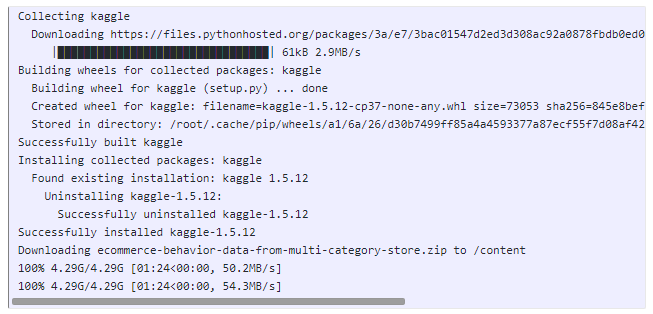

Dec'19 to Apr'20 data is available in [this](https://drive.google.com/drive/folders/1Nan8X33H8xrXS5XhCKZmSpClFTCJsSpE) drive.

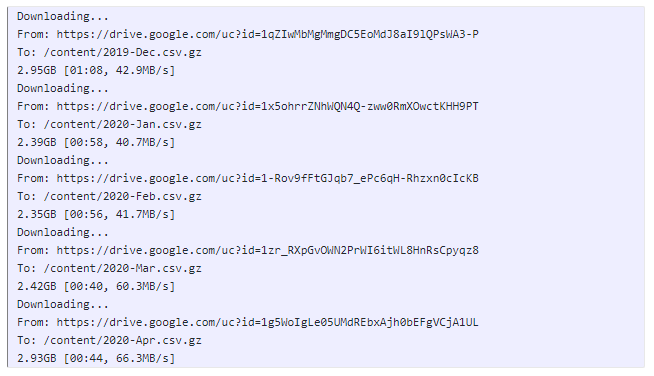

**Importance advice**: One piece of advice is to use cuDF instead of pandas. Analyzing the dataset requires calculating different groupby combination multiple times by a data scientist. GPU acceleration can significantly speed up the calculations and enables you to run more comparisons.*

### Statistics

This dataset contains 285 million users' events from the eCommerce website.

### Data split

We split the dataset into train, validation and test set by the timestamp:

- Training: October 2019 - February 2020
- Validation: March 2020
- Test: April 2020

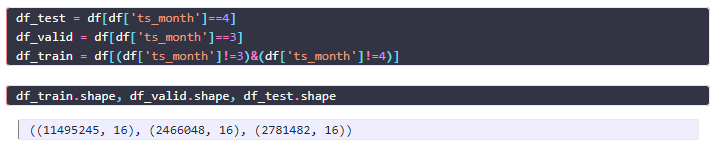

### Pre-filtering

We remove AddToCart Events from a session, if in the same session the same item was purchased.

### Transformation

```python
def process_files(df_tmp, chunkname):
    df_tmp['session_purchase'] =  df_tmp['user_session'] + '_' + df_tmp['product_id'].astype(str)
    df_purchase = df_tmp[df_tmp['event_type']=='purchase']
    df_cart = df_tmp[df_tmp['event_type']=='cart']
    df_purchase = df_purchase[df_purchase['session_purchase'].isin(df_cart['session_purchase'])]
    df_cart = df_cart[~(df_cart['session_purchase'].isin(df_purchase['session_purchase']))]
    df_cart['target'] = 0
    df_purchase['target'] = 1
    df = pd.concat([df_cart, df_purchase])
    df = df.drop('category_id', axis=1)
    df = df.drop('session_purchase', axis=1)
    # df[['cat_0', 'cat_1', 'cat_2', 'cat_3']] = df['category_code'].str.split("\.", n = 3, expand = True).fillna('NA')
    df['brand'] = df['brand'].fillna('NA')
    # df = df.drop('category_code', axis=1)
    df['timestamp'] = pd.to_datetime(df['event_time'].str.replace(' UTC', ''))
    df['ts_hour'] = df['timestamp'].dt.hour
    df['ts_minute'] = df['timestamp'].dt.minute
    df['ts_weekday'] = df['timestamp'].dt.weekday
    df['ts_day'] = df['timestamp'].dt.day
    df['ts_month'] = df['timestamp'].dt.month
    df['ts_year'] = df['timestamp'].dt.year
    df.to_csv(chunkname, index=False)
```

### ETL

We downloaded the datasets, extracted them, applied transformation, applied split, and exported in parquet files. Here is how we will load this dataset for EDA and modeling:



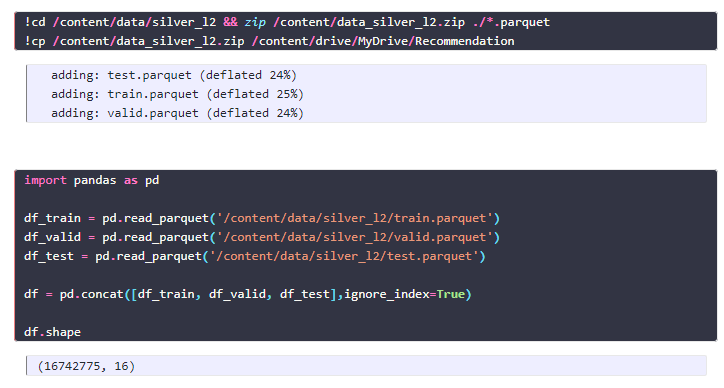

## EDA

Duration: 10

### Sparse feature frequence analysis

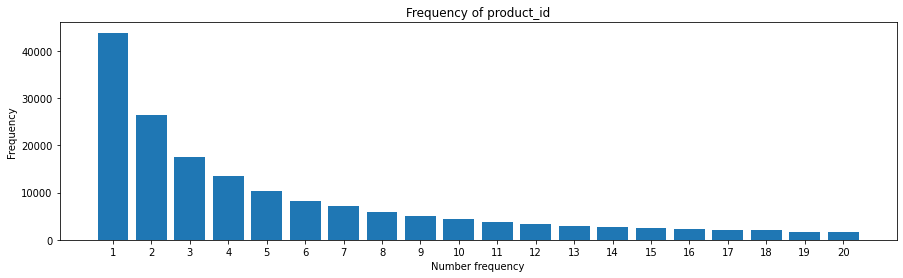

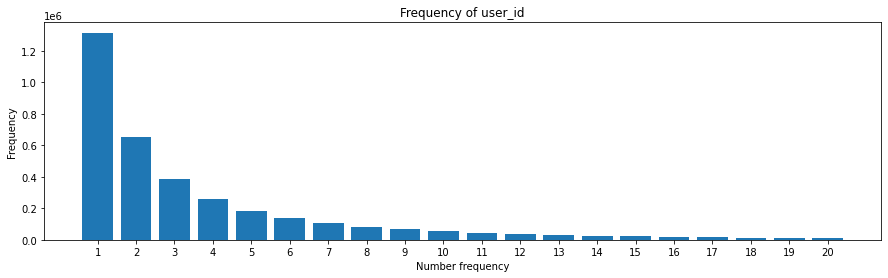

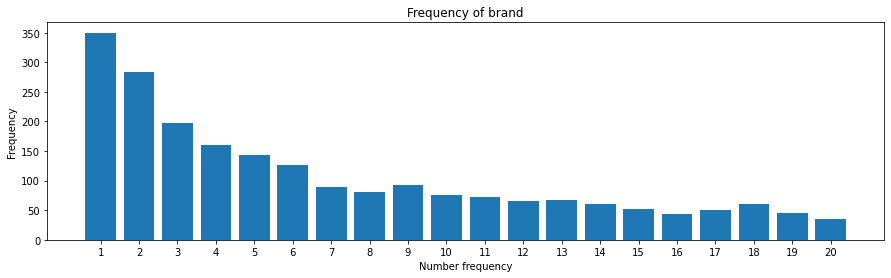

We can observe following pattern:

- There are ~45000 products which appear only once in the dataset
- There are 1200000 users which appear only once in the dataset
- There are 350 brands which appears only once in the dataset

The sparsity is important for understanding which features can be better used in a model. Product_id and User_id have many values which appear only once and the model is less able to learn a good patterns from them. On the other hand, brands has many observations and can be leveraged for prediction.

### Top frequency items analysis

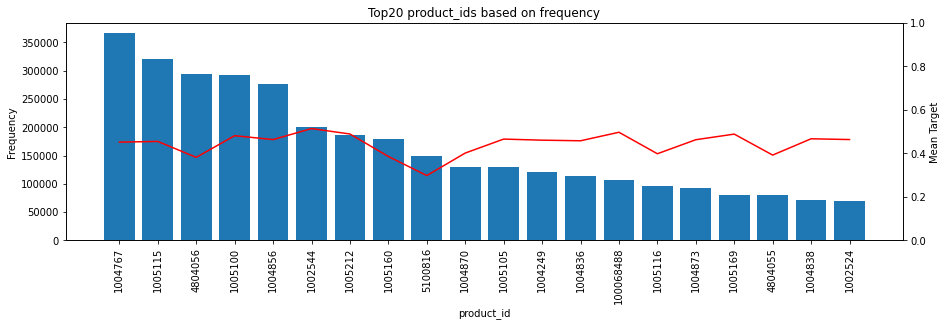

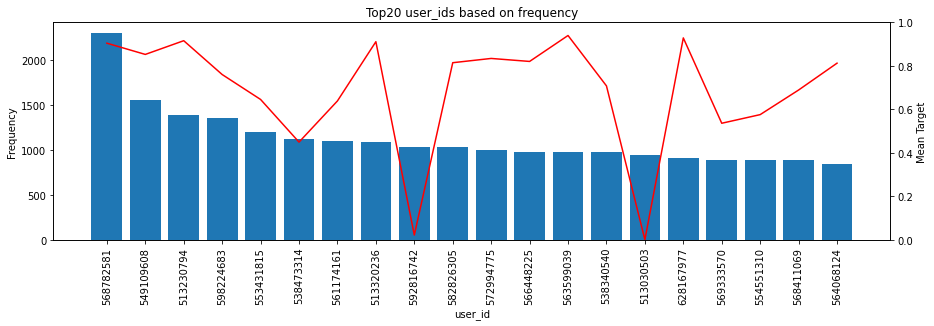

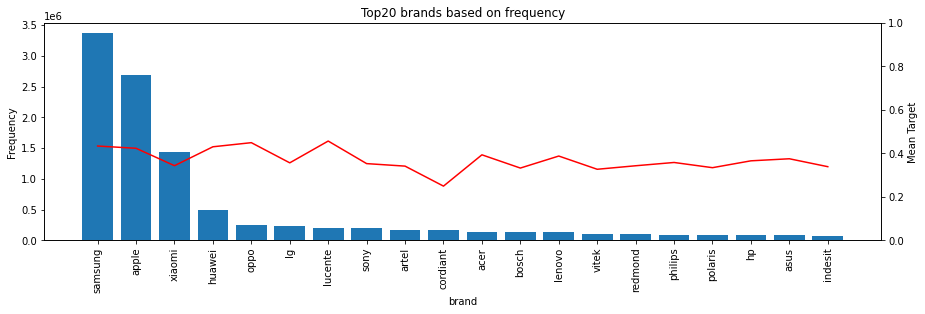

- We explored the data and saw the different raw features available in the dataset.
- We analzyed basic statistics of the raw features and saw long-tail distribution for categorical features (user, item, brand)
- Some categorical features (categories) have high occurances
- In general, we see that categorical features have variance in the target, which we can leverage to engineer more powerful features

<!---------------------------->

## Missing Value Handling

Duration: 5

Categorical Features: Imputing categorical features is easy - a unique category value (e.g. "UNKNOWN") can be imputed

Important: Before imputing the missing values, it is beneficial to create a indicator column, which indicate if the a value was imputed or not. There is maybe a underlying pattern for the missing values and models can learn the pattern.

```python
cols = ['brand', 'user_session', 'cat_0', 'cat_1', 'cat_2', 'cat_3']

for col in cols:
    df_train['NA_' + col] = df_train[col].isna().astype(np.int8)
    df_train[col].fillna('UNKNOWN', inplace=True)
```

Numerical Features: Imputing median for the numerical value (per group) Imputing mean for numercial value (per group) In some cases, we may know what value should be used as the default value (e.g. 0 for historical data or the max)

Important: For the same reason as in the categorical case, it is important to add a indicator column that the datapoint was imputed.

In our case, we do not have missing values in the numerical column price. Therefore, we artificially inject nans and then compare the difference.



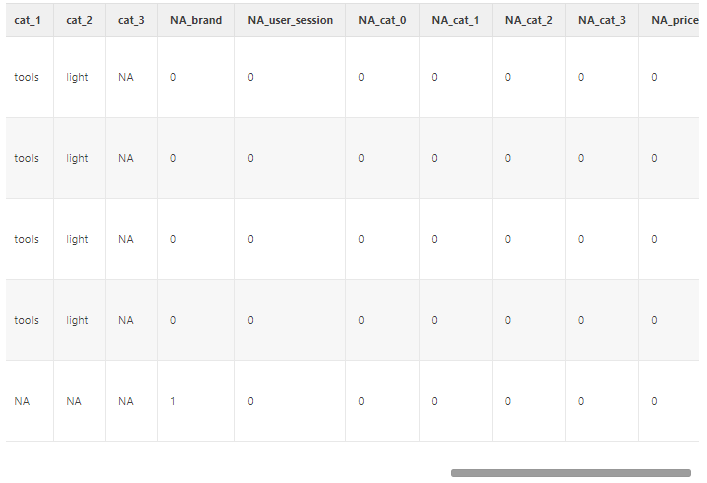

Predicting missing values: In [Improving Deep Learning For Airbnb Search](https://arxiv.org/abs/2002.05515), the authors propose to use a DNN for missing user engagement features of new items (listenings). New items have no historical user engagements, such as # of views, # of bookings, etc.. In the paper, they train a DNN based on the meta information, such as price, location and predict the user engagements feature. This could be interpreted in what are the expected user engagement.

Instead of the hand-crafted default values for missing user engagement, the authors replaced the missing values with the prediction of the DNN and showed that it reduced the error by 43% (offline test) and improved the overall bookings by 0.38% (online A/B test).

<!---------------------------->

## Feature Cross

Duration: 10

*Combining Categories (CC)* is a simple, powerful technique, but often undervalued. We will use this strategy in other feature engineering techniques, as well, and will introduce its value in a simple example.

In some datasets, categories by itself provide no information to predict the target. But if we combine multiple categories, together, then we can indentify patterns.

For example, we have the following categories:

- Weekday
- Hour of the day

Each of them independently has no significant pattern in the dataset. If we combine them with Weekday_HourOfTheDay, then we can observe some strong behavior for certainn times on the weekend

Decision Trees determine the split in the dataset on single features. If each categorical feature by itself does not provide the information gain, then Decision Trees cannot find a good split. If we provide a combined categorical feature, the Decision Tree can easier split the dataset.

Combining categories also called Cross Column or Cross Product, is used in the Wide Deep Architecture by Google and is implemented in Tensorflow.

### Best Practices!

- Combining low cardinal categories is a good start. For example, the dataset size is 100M rows and there are multiple categories with a caridnality (# of unique values) of 10-50, then combining them should not result in low observation count
- Exploratory Data Analysis (EDA) is faster than training a model. Analyzing the information value for different combination of categorical features (on a sample) is really fast.

### Implementation

```python
def explore_cat(df, cats):
    df_agg = df_train[cats + ['target']].groupby(cats).agg(['mean', 'count']).reset_index()
    df_agg.columns = cats + ['mean', 'count']
    print(df_agg.sort_values('count', ascending=False).head(20))
    
cats = ['product_id', 'user_id']  
explore_cat(df_train, cats)
```



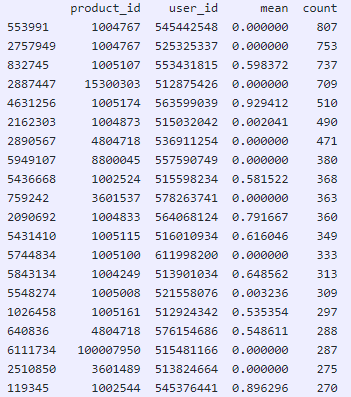

### Hypothesis based on the outcome

- Some user will always buy the same one-way products e.g. cleaning supplies, food
- Behavior changes on weekday+hour - e.g. during the week, users will not stay up late as they work next day
- Category and brand are both powerful features, but the combination can be more important. E.g. do people buy apple smartphones or accessories?

<!---------------------------->

## Categorify

Duration: 5

*Categorifying* is required for using categorical features in deep learning models with Embedding layers. An Embedding layer encodes the category into a hidden latent vector with a smaller dimension.

Categorical features can be from datatype String or Integer. The Embedding layer requires that categorical features are continuous, positive Integers from 0 to |C| (number of unique category values).

Another important reason to Categorify categorical features is to reduce the size of the dataset. Often categorical features are of the data type String and sometimes, they are hashed to protect the user/dataset privacy. For example, we can hash the Integer 0 to an md5 hash. 

Finally, we can prevent overfitting for low frequency categories. Categories with low frequency can be grouped together to an new category called 'other'. In the previous exercise we learned that it is powerful to combine categorical features together to create a new feature. However, combining categories increases the cardinality of the new feature and the number of observations per category will decrease. Therefore, we can apply a treshhold to group all categories with lower frequency count to the the new category.

In addition, categories, which occurs in the validation dataset and do not occur in the training dataset, should be mapped to the 'other' category as well.

We use in our example the category Ids 0 or 1 for a placeholder for the low frequency and unkown category. Then our function is independent of the cardinality of the categorical feature and we do not keep records of the cardinality to know the low frequency/unkown category.

In our dataset, we see that multiple product_ids occur only once in the training dataset. Our model would overfit to these low frequency categories.

<!---------------------------->

## Target Encoding

Duration: 5

*Target Encoding (TE)* calculates the statistics from a target variable grouped by the unique values of one or more categorical features.

For example in a binary classification problem, it calculates the probability that the target is true for each category value - a simple mean.

Target Encoding creates a new features, which can be used by the model for training. The advantage of Target Encoding is, that it process the categorical features and makes them easier accessible to the model during training and validation.

Tree-based model requires to create a split for each categorical value (depending on the exact model). Target Encoding saves to create many splits for the model. In particular, when applying Target Encoding to multiple columns, it reduces significantly the number of splits. The model can directly operate on the probablities/averages and creates a split based on them. Another advantage is, that some boosted-tree libraries, such as XGBoost, cannot handle categorical features. The library requires to hot-n encode them. Categorical features with large cardinality (e.g. >100) are inefficient to store as hot-n.

Deep learning models often apply Embedding Layers to categorical features. Embedding layer can overfit quickly and categorical values with low frequencies have ony a few gradient descent updates and can memorize the training data.

### Smoothing

The introduced Target Encoding is a good first step, but it lacks to generalize well and it will tend to overfit, as well. We can observe, that the observation count for some categories are 1. This means, that we have only one data point to calculate the average and Target Encoding overfits to these values. Therefore, we need to adjust the calculation:

- if the number of observation is high, we want to use the mean of this category value
- if the number of observation is low, we want to use the global mean


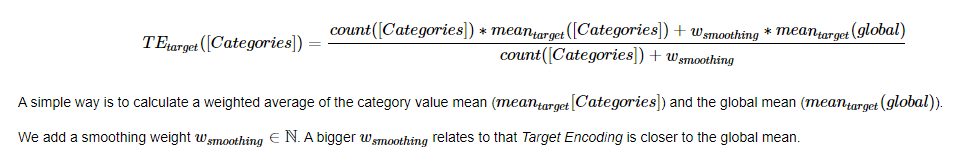

### **Improve TargetEncoding with out-of-fold**

We can still improve our Target Encoding function. We can even make it more generalizable, if we apply an out of fold calculation.

In our current definition, we use the full training dataset to Target Encode the training dataset and validation/test dataset. Therefore, we will likely overfit slightly on our training dataset, because we use the information from it to encode the categorical values. A better strategy is to use out of fold:

- use the full training dataset to encode the validation/test dataset
- split the training dataset in k-folds and encode the i-th fold by using all folds except of the i-th one

The following figure visualize the strategy for k=5:

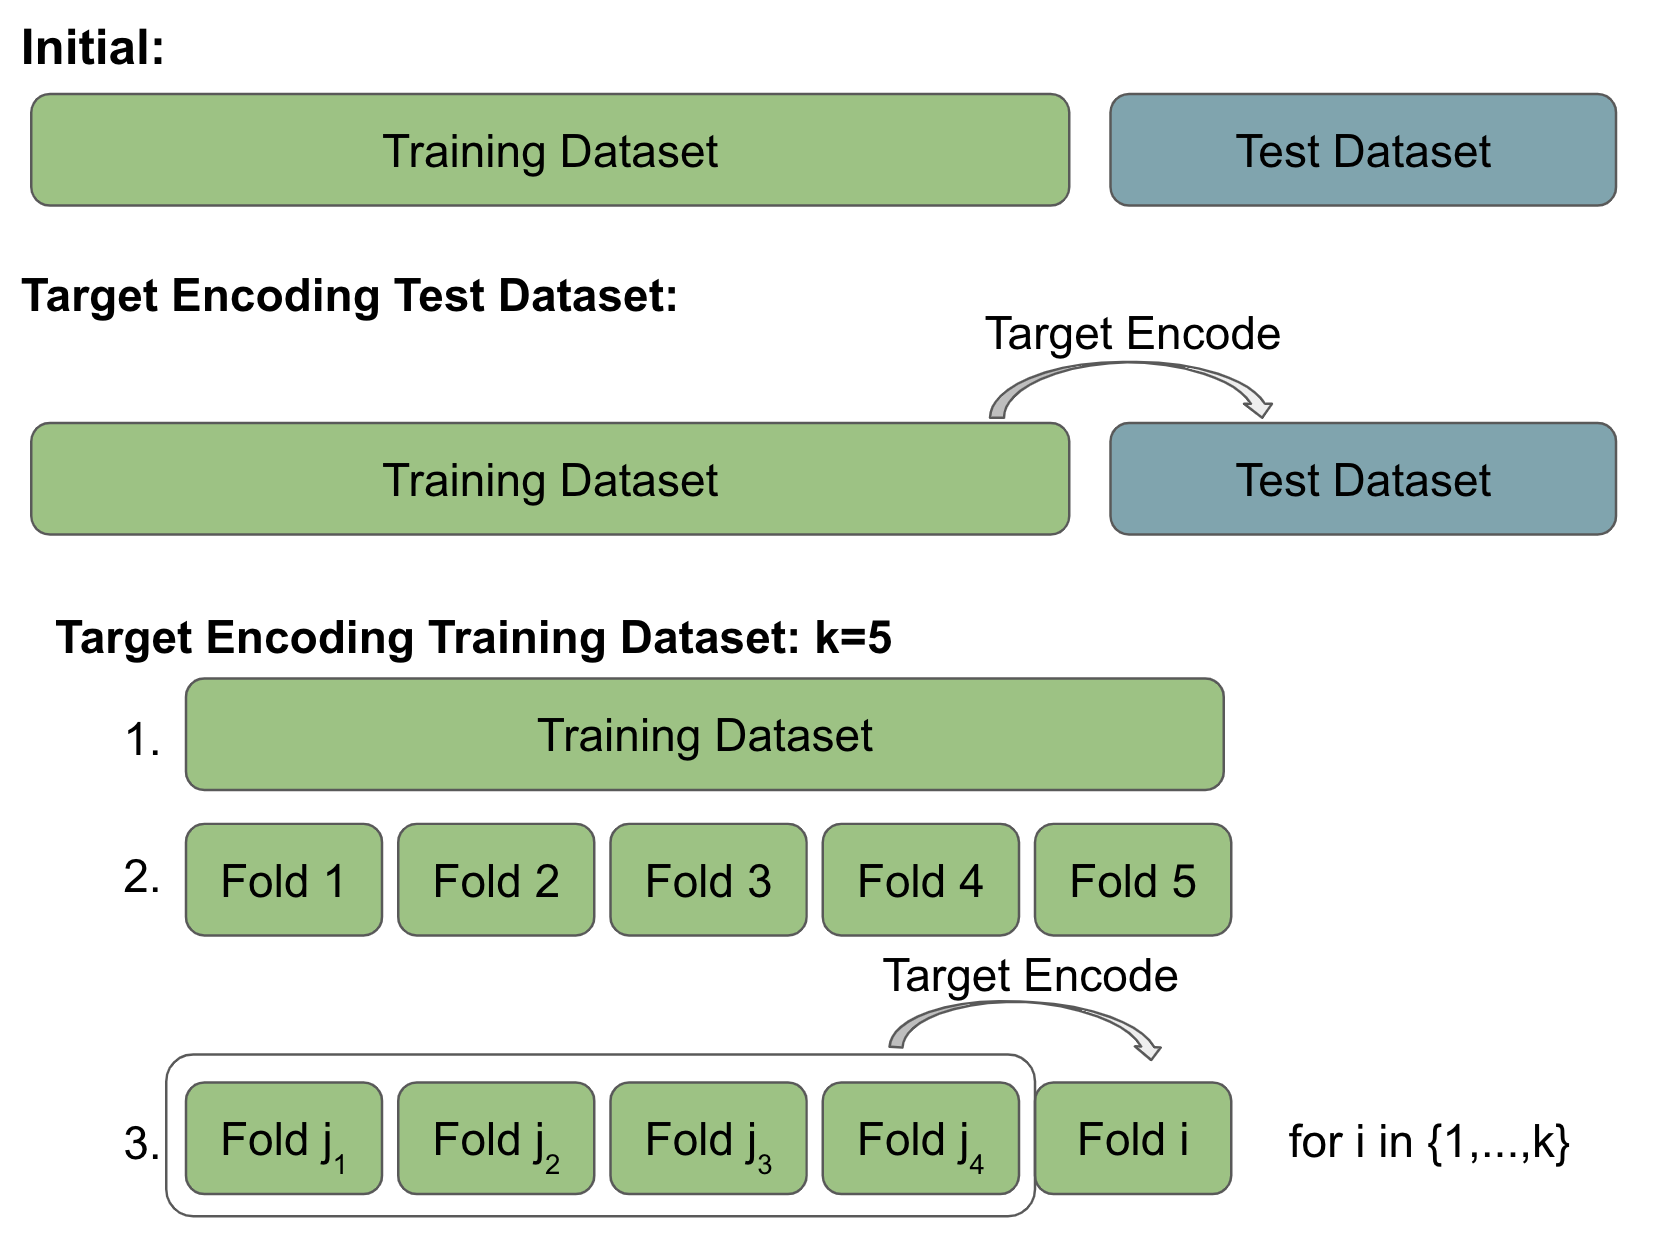

### Summary

- Target Encoding calculates statistics of a target column given one or more categorical features
- Target Encoding smooths the statistics as a weighted average of the category value and the global statistic
- Target Encoding uses a out-of-fold strategy to prevent overfitting to the training dataset.

We can see the advantage of using Target Encoding as a feature engineering step. A tree-based model or a neural network learns the average probability for the category value. However, neither model is designed to prevent overfitting.

<!---------------------------->

## Count Encoding

Duration: 5

*Count Encoding (CE)* calculates the frequency from one or more categorical features given the training dataset.

For example we can consider Count Encoding as the populiarity of an item or activity of an user.

Count Encoding creates a new feature, which can be used by the model for training. It groups categorical values based on the frequency together.

For example,

users, which have only 1 interaction in the datasets, are encoded with 1. Instead of having 1 datapoint per user, now, the model can learn a behavior pattern of these users at once. products, which have many interactions in the datasets, are encoded with a high number. The model can learn to see them as top sellers and treat them, accordingly.

The advantage of Count Encoding is that the category values are grouped together based on behavior. Particularly in cases with only a few observation, a decision tree is not able to create a split and neural networks have only a few gradient descent updates for these values.

<!---------------------------->

## Binning

Duration: 5

*Binning* maps multiple ordinal categorical or numerical features into groups. It is mainly applied to numerical features:

- prevent overfitting by grouping values together
- enables us to add some expert knowledge into the model
- most simple case: binary flags, e.g. features is greater than 0

Examples:

- binning weekdays into weekday and weekend
- binning hours into morning, early afternoon, late afternoon, evening and night
- binning age into child, adlult and retired

We can take a look on the hour of the day. We can see multiple patterns:

- 0-3 Night: Low purchase probability
- 4-7 Early morning: Mid purchase probability
- 8-14 Morning/Lunch: Higher purchase probability
- 15-20 Afternoon: Low purchase probability
- 21-23: Evening: High purchase probability

Binning the numerical features reduces the cardinality (# of unique values). Therefore, a model can easier learn the relationship to the target variables, as there are more observation per category. In addition, binning prevents overfitting.

Another reason to apply binning is to standardize numeric variables per category group. The datasets provides information about the product category (cat_1) and price information.

For example, the headphones and smartphones have a different price distribution.

- We can probably buy good headphones between 100−200
- For a good smartphone, prices are probably in the range of 400−1200

Therefore, the buying behavior should be different depending on the price per category (what is a good deal).

### Apply binning



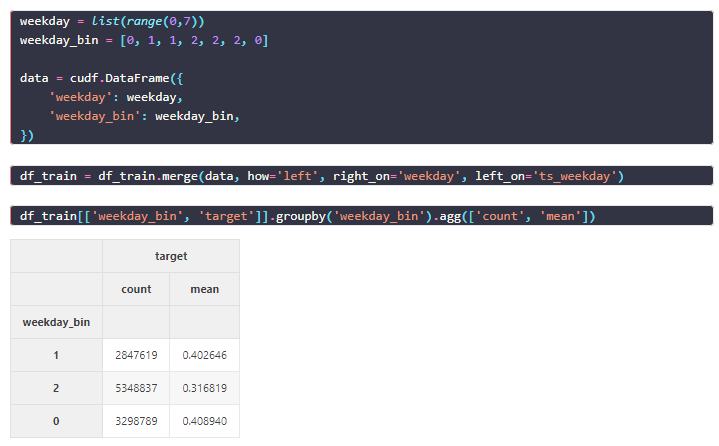

It is maybe counterintuitive:

- the highest days are Sunday and Monday - a hypothesis could be that people shop on Sunday evening and the first day of the week
- the lowest days are Thur-Sat - a hypothesis could be that Thu/Fri is end of week and people are finishing up their work and have no time to do online shopping
- Saturday is maybe a day go outside

<!---------------------------->

## Normalization

Duration: 5

*Normalization* is required to enable neural networks to leverage numerical features. Tree-based models do not require normalization as they define the split independent of the scale of a feature. Without normalization, neural networks are difficult to train. The image visualizes the loss surface and the gradient updates for non-normalized input (left) and normalized input (right).

We will first generate some numerical features with the feature engineering that we also covered in previous steps.

The reason is that different numerical features have different scales. When we combine the features in a hidden layer, the different scales make it more difficult to extract patterns from it.

Normalization Techniques After we outline the importance for normalizing the numerical input feature, we will discuss different strategy to achieve a normal distributed input feature:

- Normalization with mean/std
- Log-based normalization
- Scale to 0-1
- Gauss Rank (separate notebook)
- Power transfomer

### Gauss Rank

Gauss Rank transforms any arbitrary distribution to a Gaussian normal distribution by

1. Compute the rank (or sort the values ascending)
2. Scale the values linearly from -1 to +1
3. Apply the erfinv function



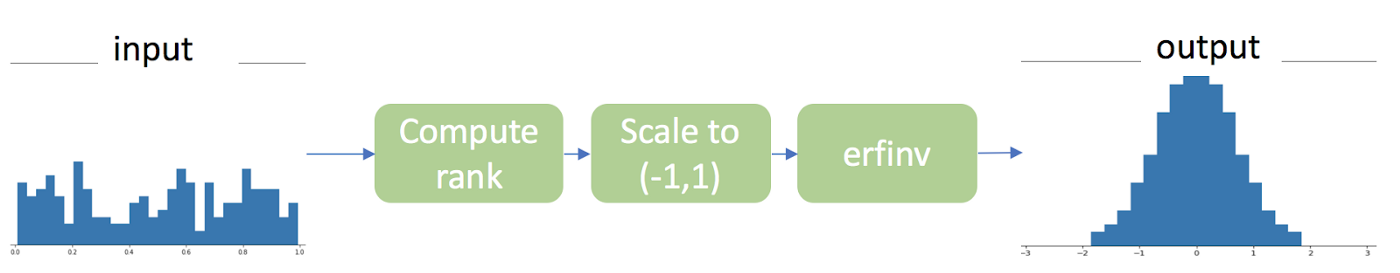

Let's normalize the features price, TE_ts_weekday_ts_hour_cat_2_brand and CE_cat_2 with GaussRank, and plot the non-normalized and normalized values

```python
fig, axs = plt.subplots(3, 2, figsize=(16,9))
for i, col in enumerate(['price', 'TE_ts_weekday_ts_hour_cat_2_brand', 'CE_cat_2']):
    data_sample = df_train[col].sample(frac=0.01)
    axs[i, 0].hist(data_sample.to_pandas(), bins=50)
    axs[i, 1].hist(cp.asnumpy(gaussrank_gpu(data_sample.values)), bins=50)
    if i==0:
        axs[i, 0].set_title('Histogram non-normalized')
        axs[i, 1].set_title('Histogram Gauss Rank')
```

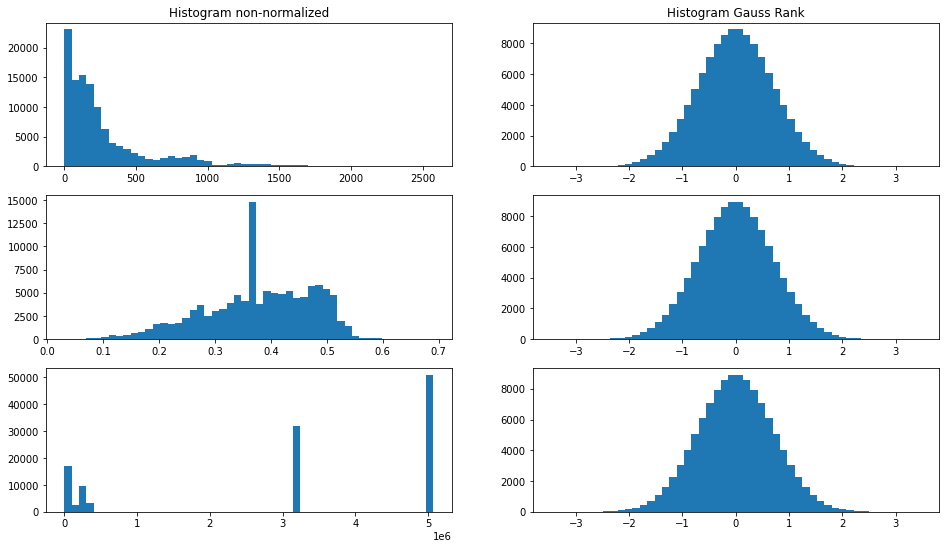

## Timeseries events

Duration: 5

Many real-world recommendation systems contain time information. The system normally logs events with a timestamp. Tree-based or deep learning based models usually only uses the information from the datapoint itself for the prediction and they have difficulties to capture relationships over multiple datapoints.

Let's take a look at a simple example. Let's assume we have the interaction events of an itemid, userid and action with the timestamp.

We can extract many interesting features based on the history, such as

- the sum number of actions of the last day, last 3 days or last 7 days
- the average number of actions of the last day, last 3 days or last 7 days
- the average probability of the last day, last 3 days or last 7 days etc.

In general, these operations are called window function and uses .rolling() function. For each row, the function looks at a window (# of rows around it) and applies a certain function to it. Currently, our data is on a userid and itemid level. First, we need to aggregate it on the level, we want to apply the window function.

We are interested in how much positive interaction an item had on the previous day. Next, we want to groupby our data frame by itemid. Then we apply the rolling function for two days (2D). Note: To use the rolling function with days, the data frame index has to by a timestamp. We can see that every row contains the sum of the row value + the previous row value. For example, itemid=1000001 for data 2020-01-02 counts 15 observations and sums 12 positive interactions.

If we take a look on the calculations, we see that the .rolling() inclues the value from the current row, as well. This could be a kind of data leakage. Therefore, we shift the values by one row.

<!---------------------------->

## Differences

Duration: 5

Another category of powerful features is to calculate the differences to previous datapoints based on a timestamp. For example, we can calculate if the price changed of a product and how much the price change was. Tree-based or deep learning based models have difficulties processing these relationships on their own. Providing the models with these features can significantly improve the performance. 

We can combine techniques of TimeSeries data and chain them together. For example, we can calculate the # of purchases per item and then compare the previous week with a the week, 2, 3 or 5 weeks ago. We can recognize patterns over time.

<!---------------------------->

## Conclusion

Duration: 2

Congratulations!

### What we've covered

1. ETL the raw data
2. Exploratory analysis
3. Feature engineering techniques
4. Time series feature techniques
5. Install and use RapidsAI's cuDF for faster processing 

### Links and References

1. [https://github.com/rapidsai/deeplearning/tree/main/RecSys2020Tutorial](https://github.com/rapidsai/deeplearning/tree/main/RecSys2020Tutorial)
2. [Official notebooks](https://nbviewer.jupyter.org/github/rapidsai/deeplearning/tree/main/RecSys2020Tutorial/)
3. [Official video tutorial](https://youtu.be/uROvhp7cj6Q?list=PLaZufLfJumb-cVIEsyg4CFocuq4WsvjED)